**Long short-term memory (LSTM) RNN**

Gabriela Dobbert Sanches<br>
Pedro Henrique Cavalcante

Na área de Mídias Pagas, os gestores de contas tem frequetemente o desafio de tentar "prever" como as plataformas e públicos irão se comportar para dividir o orçamento de acordo com a receita, de modo que tenha o melhor aproveitamento possível.

As análises preditivas acontecem na maioria das vezes com o uso da regressão linear. O problema é que, em sua maioria, a regressão linear não leva em conta os períodos de sazonalidades e comportamentos mais específicos de um cliente, como por exemplo: Black Friday, Cyber Monday, Semana do Consumidor, Dia do Cliente, promoções específicas do cliente. Tudo isso interfere, e muito, no total faturado do mês, e consequentemente no total investido.

Então, visando um melhor aproveitamento nesse sentido, utilizaremos a rede LSTM (Long Short-Term Memory), um tipo de rede neural recorrente (RNN) especialmente projetada para lidar com dados sequenciais e temporais. A LSTM é capaz de capturar padrões complexos e dependências de longo prazo em séries temporais, o que a torna ideal para prever comportamentos de plataformas e públicos em cenários dinâmicos, como os observados em Mídias Pagas.

A principal vantagem da LSTM em relação à regressão linear é sua capacidade de considerar sazonalidades, porque a rede possui uma arquitetura que permite "memorizar" informações relevantes ao longo do tempo, ajustando-se a mudanças abruptas ou padrões não lineares nos dados.



A LSTM possui uma estrutura em cadeia que contém quatro redes neurais e diferentes blocos de memória chamados células.

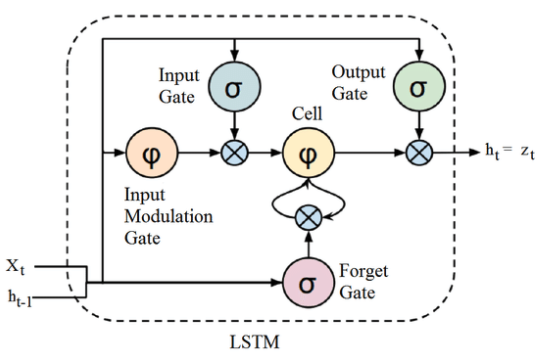

A informação é retida pelas células e as manipulações de memória são feitas pelos portões (gates). Existem três portões:

Forget Gate: O forget gate decide quais informações do estado da célula devem ser descartadas. Ele recebe duas entradas: a entrada atual (x_t) e a saída da célula anterior (h_t-1). Essas entradas são multiplicadas por pesos, somadas a um bias e passadas por uma função de ativação que gera uma saída binária (0 ou 1). Se a saída for 0, a informação é esquecida; se for 1, ela é mantida para uso futuro.

Input Gate: O input gate adiciona novas informações ao estado da célula. Ele usa as mesmas entradas (h_t-1 e x_t) para regular quais valores devem ser lembrados, passando-os por uma função sigmoide. Em seguida, um vetor é criado usando a função tanh, que varia de -1 a +1, contendo todos os valores possíveis das entradas. Esse vetor é multiplicado pelos valores regulados para adicionar as informações úteis ao estado da célula.

Output Gate: O output gate extrai informações úteis do estado atual da célula para gerar a saída. Primeiro, a função tanh é aplicada ao estado da célula para criar um vetor. Depois, a função sigmoide filtra quais valores devem ser lembrados, usando as entradas h_t-1 e x_t. O vetor e os valores filtrados são multiplicados para produzir a saída, que também é usada como entrada para a próxima célula.

A célula RNN recebe duas entradas: a saída do último estado oculto (h_t-1) e a observação no tempo atual (x_t). Além do estado oculto, não há informações sobre o passado. A memória de longo prazo é armazenada no estado da célula, que é modificado pelo forget gate (que descarta informações) e pelo input gate (que adiciona novas informações). O estado da célula é atualizado multiplicando-se o estado anterior pelo forget gate e somando as novas informações do input gate. Isso permite que a célula LSTM mantenha informações de intervalos anteriores de forma eficiente.

Imports e leitura do Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import kagglehub
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def generate_fake_sales_data(num_months=24, seed=1):
    np.random.seed(seed)

    date_range = pd.date_range('2010-01-01', periods=num_months, freq='M')

    # Gera valores fictícios de "gasto/receita" por canal
    google_ads = np.random.uniform( 500, 5000, num_months)
    facebook_ads = np.random.uniform(300, 3000, num_months)
    instagram_ads = np.random.uniform(200, 2000, num_months)

    # Supondo que o faturamento seja uma combinação (soma) dessas mídias
    # + uma base fixa + algum ruído normal
    base_faturamento = 10000  # base de faturamento
    ruido = np.random.normal(loc=0, scale=500, size=num_months)  # ruído
    faturamento = base_faturamento + (google_ads + facebook_ads + instagram_ads)*1.2 + ruido

    df = pd.DataFrame({
        'Date': date_range,
        'Google_Ads': google_ads,
        'Meta_Ads': facebook_ads,
        'TikTok_Ads': instagram_ads,
        'Faturamento': faturamento
    })

    return df

df = generate_fake_sales_data(num_months=240) #período de 20 anos para melhor aprendizado
print(df.head(10))

        Date   Google_Ads     Meta_Ads   TikTok_Ads   Faturamento
0 2010-01-31  2185.430535  2839.238178  1332.917549  17672.398407
1 2010-02-28  4778.214379  2875.607158  1452.347640  20849.564395
2 2010-03-31  3793.972738  2770.133854  1018.173917  19682.627641
3 2010-04-30  3193.963179  1299.428491  1329.604544  17114.805878
4 2010-05-31  1202.083882   341.732865  1251.765761  13523.500341
5 2010-06-30  1201.975342  2806.460119  1822.084419  16790.685372
6 2010-07-31   761.376255  1456.097200   281.803485  12755.329216
7 2010-08-31  4397.792656  2909.968011   705.733741  19399.914196
8 2010-09-30  3205.017553  2901.773938  1910.740671  19818.264666
9 2010-10-31  3686.326600  2603.125530  1802.474811  19499.820089


<ipython-input-13-8614ea01345d>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range('2010-01-01', periods=num_months, freq='M')


Nessa parte do código, criamos dados ficticios de um cliente que usa as 3 plataformas de mídias pagas. O faturamento é a soma do faturamento das 3 plataformas, mais algum ruído devido ao faturamento orgânico.

Normalização dos dados


In [ ]:
cols = ['Google_Ads', 'Meta_Ads', 'TikTok_Ads', 'Faturamento']
data = df[cols].to_numpy()

split_idx = int(len(data) * 0.8)
train_data = data[:split_idx]
test_data  = data[split_idx:]

scaler = MinMaxScaler()
scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data  = scaler.transform(test_data)

gamma = 0.1

EMA_train = np.zeros(train_data.shape[1])
for i in range(len(train_data)):
    EMA_train = gamma * train_data[i] + (1 - gamma) * EMA_train
    train_data[i] = EMA_train

EMA_test = np.zeros(test_data.shape[1])
for i in range(len(test_data)):
    EMA_test = gamma * test_data[i] + (1 - gamma) * EMA_test
    test_data[i] = EMA_test

print("Formato do treino:", train_data.shape)
print("Formato do teste:", test_data.shape)

Formato do treino: (192, 4)
Formato do teste: (48, 4)


Nesta célula, extraímos os valores máximos e mínimos de cada dia e calculamos o “mid price”. Em seguida, dividimos os dados em partes: treino e teste. Usamos o MinMaxScaler para deixar todos os valores de treino em uma escala de 0 a 1, de forma a facilitar o treinamento da rede. Também aplicamos uma “suavização exponencial” que reduz ruídos nos dados de treino.

Criação de sequências

In [ ]:
def create_sequences_multi(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 6
X_train, y_train = create_sequences_multi(train_data, window_size)
X_test,  y_test  = create_sequences_multi(test_data, window_size)

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape  =", X_test.shape)
print("y_test.shape  =", y_test.shape)

X_train.shape = (186, 6, 4)
y_train.shape = (186, 4)
X_test.shape  = (42, 6, 4)
y_test.shape  = (42, 4)


Aqui, definimos uma função que “quebra” a série de preços em blocos de tamanho fixo. Para cada janela de 6 pontos, ou seja, 6 meses, o objetivo da rede é prever o ponto seguinte. É assim que ensinamos a LSTM a aprender a dinâmica temporal de uma série.

Estruturação do modelo LSTM



In [ ]:
model = keras.Sequential()

model.add(keras.layers.LSTM(
    200, return_sequences=True,
    input_shape=(window_size, 4)
))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(200, return_sequences=True))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(150))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(4))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error'
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 6, 200)              │         164,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 6, 200)              │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             604 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 696,004 (2.66 MB)

 Trainable params: 696,004 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Aqui criamos o nosso modelo LSTM usando keras.Sequential(). Ele possui três camadas LSTM empilhadas (200, 200 e 150 neurônios), com return_sequences=True nas primeiras duas, para que a informação flua passo a passo entre elas. Cada camada LSTM é seguida por um Dropout de 20% para evitar overfitting. Por fim, adicionamos uma camada densa com 4 neurônios como saída (nossas predições para cada plataforma). Usamos Adam como otimizador e definimos o erro quadrático médio como a métrica de perda.

Treinamento do modelo

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - loss: 0.2238 - val_loss: 0.2098
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2136 - val_loss: 0.1980
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2007 - val_loss: 0.1858
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1901 - val_loss: 0.1729
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1774 - val_loss: 0.1591
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1632 - val_loss: 0.1439
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1457 - val_loss: 0.1273
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1294 - val_loss: 0.1091
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1116 - val_loss: 0.0893
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0905 - val_loss: 0.0683
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0696 - val_loss: 0.0470
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0483 - val_loss: 0.027

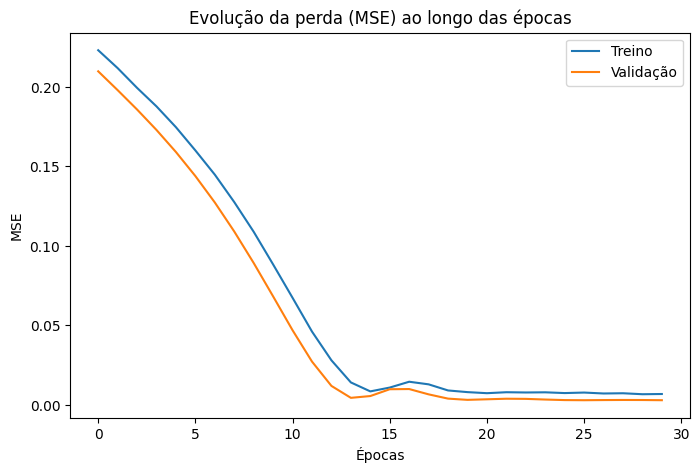

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

epochs = 30
batch_size = 64

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop] #early stopping para evitar que o modelo decore o conjunto de teste
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Evolução da perda (MSE) ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.show()

Agora treinamos o modelo chamando model.fit() e passando nossos dados X_train e y_train. Definimos que teremos 30 épocas e um tamanho de lote de 64 (tamanho do lote ou batch_size é o número de exemplos de treinamento que são processados simultaneamente antes de o modelo atualizar seus parâmetros). Também separamos automaticamente 10% dos dados para “validação”, também adicionamos o callback de earlystopping, para evitar o overfitting (assim podemos monitorar se o modelo está aprendendo ou se está “decorando” o conjunto de treino). Por fim, plotamos a perda (MSE) tanto no treino quanto na validação. Conseguimos notas que em poucas épocas o modelo reduziu consideravelmente seu loss e alcança quase um 0.

Resultados

MSE no teste = 0.003954
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step


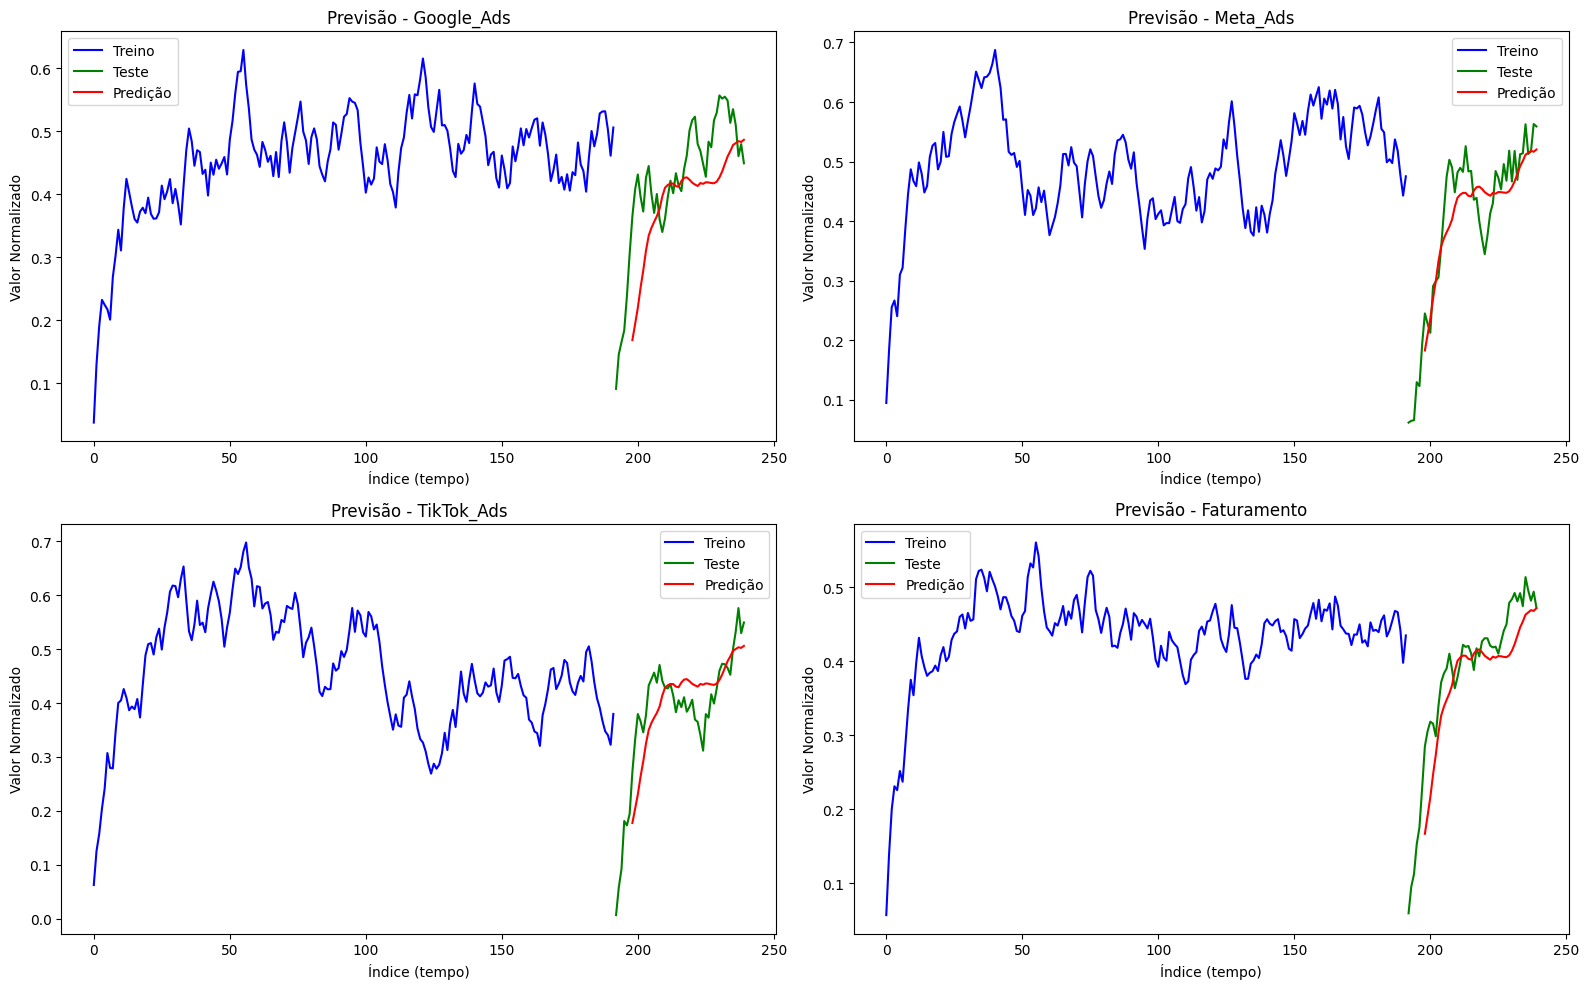

In [ ]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"MSE no teste = {test_mse:.6f}")

predictions = model.predict(X_test)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

col_names = ["Google_Ads", "Meta_Ads", "TikTok_Ads", "Faturamento"]

for idx, col_name in enumerate(col_names):
    ax = axes[idx]

    pred_plot = np.full((len(test_data),), np.nan, dtype=np.float32)

    for i in range(len(predictions)):
        pred_plot[i + window_size] = predictions[i, idx]

    ax.plot(range(len(train_data)), train_data[:, idx], label='Treino', color='blue')
    ax.plot(range(len(train_data), len(train_data) + len(test_data)), test_data[:, idx], label='Teste', color='green')
    ax.plot(range(len(train_data), len(train_data) + len(test_data)), pred_plot, label='Predição', color='red')

    ax.set_title(f"Previsão - {col_name}")
    ax.set_xlabel("Índice (tempo)")
    ax.set_ylabel("Valor Normalizado")
    ax.legend()

plt.tight_layout()
plt.show()


Nos gráficos, temos a parte de treino (azul), a parte de teste (verde) e as previsões (vermelho). Assim conseguimos observar se a previsão se aproxima ao conjunto que reservamos para teste. Nas 3 plataformas e no faturamento total, nota-se que apesar dos pontos de previsão e teste no plano não serem exatamente iguais, a linha de previsão acompanha razoavelmente bem a linha de teste.
Para um melhor resultado, talvez fosse necessário mais pontos de aprendizado, ou seja, mais meses para o dataset.

**Referências**

1. DATACAMP. LSTM em Python: Previsão do Mercado de Ações. Disponível em: https://www.datacamp.com/pt/tutorial/lstm-python-stock-market. Acesso em: 17/02/2025.

2. DEEP LEARNING BOOK BRASIL. Arquitetura de Redes Neurais Long Short-Term Memory (LSTM). Disponível em: https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/. Acesso em: 17/02/2025.